In [1]:
import numpy as np
import pandas as pd
from scipy.stats import entropy
import scipy.stats
from scipy.stats import poisson
import seaborn as sns
import sklearn.neighbors
import matplotlib.pyplot as plt
%matplotlib inline

import Levenshtein

import sys
sys.path.append('..')
from lib import *

plt.style.use('../peptidome.mplstyle')

In [2]:
df_t = load_iedb_tcellepitopes(human_only=True)

/tmp/ipykernel_74385/3096547109.py:1: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  df_t = load_iedb_tcellepitopes(human_only=True)


<AxesSubplot:>

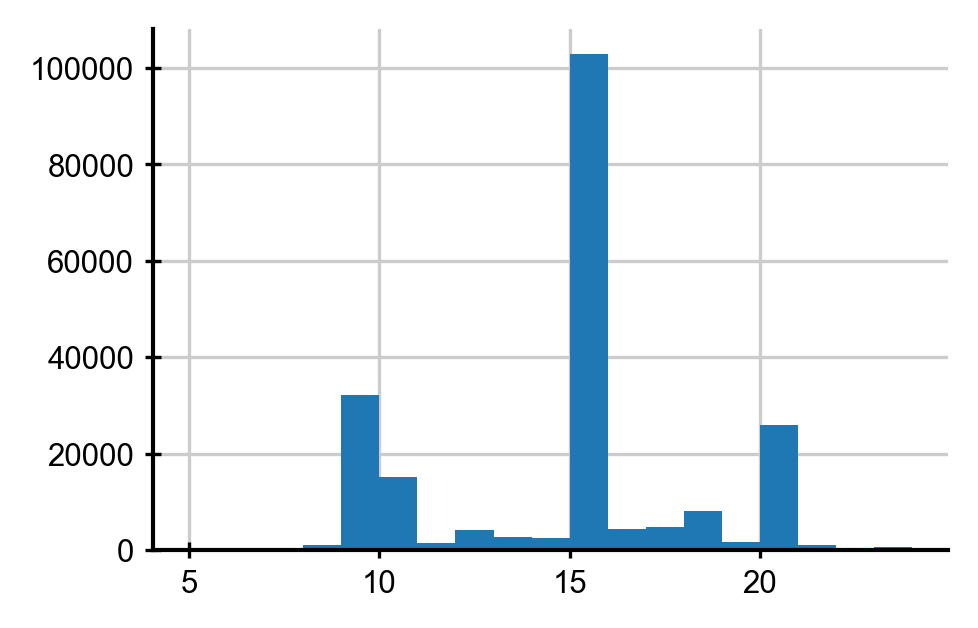

In [3]:
d = df_t[(df_t['Epitope', 'Length']>5) & (df_t['Epitope', 'Length']<25)]
d['Epitope', 'Length'].hist(bins=np.arange(5, 25, 1))

In [4]:
df_t = df_t[(df_t['Epitope', 'Length']<13)]

In [5]:
df_t[('Assay', 'Assay Group')].value_counts().head(10)

IFNg release                36374
proliferation                4978
cytotoxicity                 4966
qualitative binding          3918
IL-2 release                  572
TNFa release                  530
dissociation constant KD      509
IL-4 release                  344
CCL4/MIP-1b release           328
IL-10 release                 217
Name: (Assay, Assay Group), dtype: int64

In [6]:
d = df_t[df_t[('Assay', 'Assay Group')].isin(df_t[('Assay', 'Assay Group')].value_counts().head(10).index)]
d[[('Assay', 'Assay Group'), ('Assay', 'Positive')]].groupby(('Assay', 'Assay Group')).agg('mean').head(10)

,Assay
,Positive
"(Assay, Assay Group)",
CCL4/MIP-1b release,0.917683
IFNg release,0.263375
IL-10 release,0.691244
IL-2 release,0.811189
IL-4 release,0.787791
TNFa release,0.847170
cytotoxicity,0.810914
dissociation constant KD,0.886051


In [7]:
df_t['Assay', 'Method/Technique'].value_counts().head(10)

ELISPOT                            31768
3H-thymidine                        4485
51 chromium                         4193
multimer/tetramer                   3911
ICS                                 3876
ELISA                               3007
in vitro assay                       845
biological activity                  564
surface plasmon resonance (SPR)      481
binding assay                        440
Name: (Assay, Method/Technique), dtype: int64

In [8]:
d = df_t[df_t[('Assay', 'Method/Technique')].isin(df_t[('Assay', 'Method/Technique')].value_counts().head(10).index)]
d[[('Assay', 'Method/Technique'), ('Assay', 'Positive')]].groupby(('Assay', 'Method/Technique')).agg('mean')

,Assay
,Positive
"(Assay, Method/Technique)",
3H-thymidine,0.592419
51 chromium,0.799428
ELISA,0.757233
ELISPOT,0.197841
ICS,0.732714
binding assay,0.995455
biological activity,0.840426
in vitro assay,0.857988


<AxesSubplot:xlabel='(Assay, Method/Technique)'>

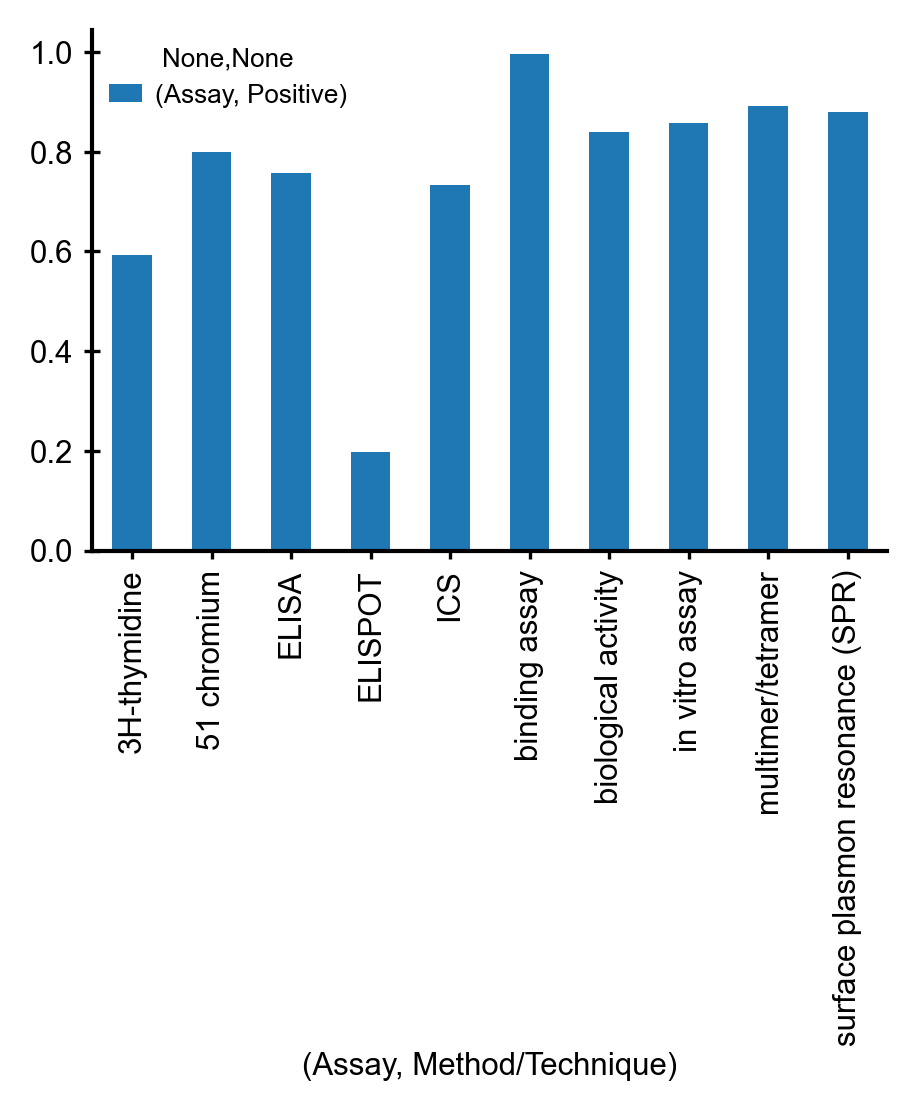

In [9]:
d[[('Assay', 'Method/Technique'), ('Assay', 'Positive')]].groupby(('Assay', 'Method/Technique')).agg('mean').plot(kind='bar')

In [10]:
ks = [8, 9, 10]
host = 'Homo sapiens'
selfset = {k:set(count_kmers_proteome(human, k, clean=True)) for k in ks}

In [11]:
# only specified hosts
mask = df_t['Host', 'Name'].str.match(host, na=False)
# only epitopes of length k
#mask &= df_t['Epitope', 'Description'].apply(len)==k
# only epitopes of lengths in k
mask &= df_t['Epitope', 'Description'].apply(len).isin(ks)
# no host epitopes or epitopes of unknown provenance
mask &= ~df_t['Epitope', 'Parent Species'].str.contains(host, na=True)
# exclude autoimmune epitopes
mask &= ~(df_t['1st in vivo Process', 'Process Type'] == 'Occurrence of autoimmune disease')
# exclude rare assay types
mask &= df_t[('Assay', 'Method/Technique')].isin(df_t[('Assay', 'Method/Technique')].value_counts().head(6).index)
df_t_f = df_t[mask]
d0 = df_t_f['Epitope', 'Description'].apply(lambda x: max([x in self for self in selfset.values()]))

In [12]:
df_t_f[df_t_f['Assay', 'Method/Technique']=='ELISPOT']['Assay', 'Assay Group'].value_counts()

IFNg release          29546
granzyme B release       50
IL-10 release            19
TNF release              12
IL-4 release              3
IL-2 release              3
IL-17 release             1
Name: (Assay, Assay Group), dtype: int64

In [13]:
df_t_f[d0]['Epitope', 'Parent Species'].value_counts()

Vaccinia virus                   104
Human endogenous retrovirus K     13
Human betaherpesvirus 5           10
Chlamydia trachomatis              3
Mus musculus                       3
Human betaherpesvirus 6B           3
Mycobacterium tuberculosis         2
Leishmania major                   2
Human gammaherpesvirus 8           1
Plasmodium falciparum              1
Rattus norvegicus                  1
Cavia porcellus                    1
Dengue virus                       1
Name: (Epitope, Parent Species), dtype: int64

In [14]:
df_t_f[d0]['1st in vivo Process', 'Process Type'].value_counts()

Administration in vivo                                                             105
Occurrence of infectious disease                                                    25
Exposure with existing immune reactivity without evidence for disease                7
Environmental exposure to endemic/ubiquitous agent without evidence for disease      4
No immunization                                                                      4
Name: (1st in vivo Process, Process Type), dtype: int64

In [15]:
pos_d0 = df_t_f[d0][[('Assay', 'Method/Technique'),
                     ('Assay', 'Positive')]].groupby(('Assay', 'Method/Technique')).agg('mean')
pos_d0_count = df_t_f[d0][[('Assay', 'Method/Technique'),
                     ('Assay', 'Positive')]].groupby(('Assay', 'Method/Technique')).agg('count')

In [16]:
pos_all = df_t_f[[('Assay', 'Method/Technique'),
                  ('Assay', 'Positive')]].groupby(('Assay', 'Method/Technique')).agg('mean')
pos_all_count = df_t_f[[('Assay', 'Method/Technique'),
                  ('Assay', 'Positive')]].groupby(('Assay', 'Method/Technique')).agg('count')

In [17]:
dfm = pd.merge(pos_d0, pos_all, how='inner', left_index=True, right_index=True, suffixes=['_d0', '_all'])
dfm

,Assay_d0,Assay_all
,Positive,Positive
"(Assay, Method/Technique)",,
3H-thymidine,0.333333,0.871739
51 chromium,0.600000,0.772140
ELISA,0.833333,0.671274
ELISPOT,0.008403,0.170446
ICS,0.666667,0.720718
multimer/tetramer,0.833333,0.894698


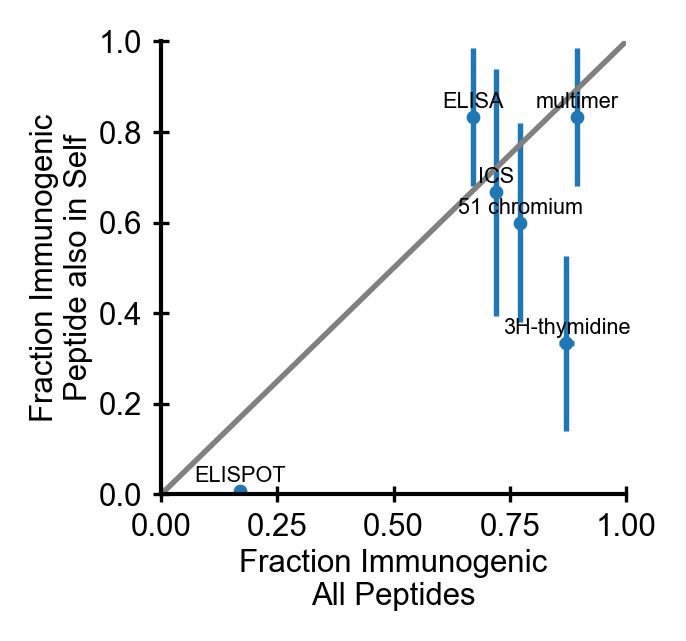

In [22]:
fig = plt.figure(figsize=(2, 2))
xs = dfm['Assay_all', 'Positive']
ys = dfm['Assay_d0', 'Positive']
counts = pos_d0_count.loc[xs.index]['Assay', 'Positive']
counts_x = pos_all_count.loc[xs.index]['Assay', 'Positive']
yerr = (ys*(1-ys)/counts)**.5
xerr = (xs*(1-xs)/counts_x)**.5
labels = dfm.index
plt.errorbar(xs, ys, yerr=yerr, xerr=xerr, fmt='o')

for x, y, label in zip(xs, ys, labels):
    plt.annotate(label.split('/')[0], (x, y+0.02), ha='center', size='xx-small')

plt.plot([0, 1], [0, 1], '-', c='.5')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel('Fraction Immunogenic\nAll Peptides')
plt.ylabel('Fraction Immunogenic\nPeptide also in Self')
fig.savefig(figuredir + 'assays.svg')